In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.special as sc
from scipy.stats import weibull_min
import pandas as pd
import os
import seaborn as sns
import sys
import math

np.set_printoptions(threshold=sys.maxsize)

distance_parameter = 1.1
kilo_diameter = 0.033

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
def load_pd_times(dirPath, experiment_type):
    if (experiment_type != "times"):
        print("experiment_type could be only $times")
        exit(-1)

    num_experiment = len([name for name in os.listdir(dirPath) if
                          (os.path.isfile(os.path.join(dirPath, name)) and (name.endswith('position.tsv')))])

    if os.path.exists(dirPath + "/" + experiment_type + ".pkl"):
        return num_experiment, pd.read_pickle(dirPath + "/" + experiment_type + ".pkl")

    print("Generating pickle times file")
    df = pd.DataFrame()
    for filename in os.listdir(dirPath):
        if filename.endswith('time_results.tsv'):
            if not os.path.getsize(os.path.join(dirPath, filename)) > 0:
                print("Error, empty file at:" + os.path.join(dirPath, filename))
                continue
            df_single = pd.read_csv(dirPath + "/" + filename, sep="\t")
            df = df.append(df_single)

    df.to_pickle(dirPath + "/" + experiment_type + ".pkl")
    return num_experiment, df

In [6]:
def load_pd_positions(dirPath, experiment_type):
    if experiment_type != "experiment" and experiment_type != "baseline":
        print("experiment_type could be only $experiment or $baseline")
        exit(-1)

    num_experiment = len([name for name in os.listdir(dirPath) if
                          (os.path.isfile(os.path.join(dirPath, name)) and (name.endswith('position.tsv')))])

    if os.path.exists(dirPath + "/" + experiment_type + ".pkl"):
        # print("Loading pickle positions file in " + dirPath + "/" + experiment_type + ".pkl")
        return num_experiment, pd.read_pickle(dirPath + "/" + experiment_type + ".pkl")
    # else:
    #     print("Baseline:"+dirPath+" not an existing path")
    #     exit(-1)

    print("Generating pickle positions file in " + dirPath + "/" + experiment_type + ".pkl")
    df = pd.DataFrame()
    for filename in os.listdir(dirPath):
        if filename.endswith('position.tsv'):
            if not os.path.getsize(os.path.join(dirPath, filename)) > 0:
                print("Error, empty file at:" + os.path.join(dirPath, filename))
                continue
            df_single = pd.read_csv(dirPath + "/" + filename, sep="\t")
            df = df.append(df_single)

    df.to_pickle(dirPath + "/" + experiment_type + ".pkl")
    return num_experiment, df

In [7]:
def distance_from_the_origin(df_values):
    distances = np.array([])
    # df_values1 = df_values[:3,:4]
    for i in range(df_values.shape[1]):
        #     print(i)
        x_pos = df_values[:, i, 0]
        y_pos = df_values[:, i, 1]
        distances = np.vstack([distances, np.sqrt(x_pos ** 2 + y_pos ** 2)]) if distances.size else np.sqrt(
            x_pos ** 2 + y_pos ** 2)
    # print(distances)
    # print("distances shape", distances.shape)
    return distances

In [8]:
# get_occurrences : returns weighted density histogram
def get_occurrences(distances, edges, runs):
    hist_val = np.array([])
    for x in distances:
        hist, _ = np.histogram(x, edges)
        #     print(i,hist)
        hist_val = np.vstack([hist_val, hist]) if hist_val.size else hist

    for i in range(edges[1:].size):
        area = np.pi * (np.square(edges[1:][i]) - np.square(edges[1:][i - 1])) if i else np.pi * np.square(edges[1:][i])
        hist_val[:, i] = np.true_divide(hist_val[:, i], area * runs)

    return hist_val

In [9]:
def check_connection(kilo1, kilo2):
    dist = np.linalg.norm(kilo1-kilo2)
    if dist <= distance_parameter * kilo_diameter:
        return 1
    else:
        return 0

In [49]:
# questa può diventare una funzione che data la singola run ritorna 
# il vettore n_clusters e il vettore biggest_clusters_per_time

def get_connected_components(single_run):
    n_clusters = np.zeros(single_run.shape[1], dtype=int)
    biggest_clusters_per_time = np.zeros(single_run.shape[1], dtype=int)
    for c in range(single_run.shape[1]):
        xi = single_run[:,c,:]
        adjacency_matrix = np.zeros([xi.shape[0],xi.shape[0]], dtype=int)
        for i,ki in enumerate(xi):
            for j,kj in enumerate (xi[i+1:]):
        #         if(check_connection(ki,kj)):
        #             print(i,i+j+1,'\t',check_connection(ki,kj))
                adjacency_matrix[i,i+j+1] = check_connection(ki,kj)
                adjacency_matrix[i+j+1,i] = check_connection(ki,kj)
    #     print(adjacency_matrix)
        adjacency_matrix = csr_matrix(adjacency_matrix) #cambiare nome
        n_cluster, cluster_labels = connected_components(csgraph=adjacency_matrix, directed=False, return_labels=True)
        n_clusters[c] = n_cluster
        biggest_clusters_per_time[c] = np.max(np.bincount(cluster_labels))
    #     print("timestep %d : num_components %d" %(c, n_cluster))
    
    return biggest_clusters_per_time, n_clusters

In [13]:
# df_experiment

In [ ]:
# print(positions_concatenated)

In [ ]:
# positions_concatenated[:,0]

In [ ]:
# positions_concatenated[:,0,:]

In [117]:
def plot_info_clusters(biggest_clusters_avg, n_clusters_avg):
    plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

    times = np.arange(n_clusters_avg.size) * 10
    
    # colors = ['red','blue','darkgreen','crimson','turquoise', 'khaki','navy', 'orangered', 'sienna']
    Ncolors = 2
    colormap = plt.cm.viridis  # LinearSegmentedColormap
    Ncolors = min(colormap.N, Ncolors)
    mapcolors = [colormap(int(x * colormap.N / Ncolors)) for x in range(Ncolors)]
    
    # biggest_clusters_avg
    plt.subplot(211)
    plt.plot(times, biggest_clusters_avg, marker='.', color=mapcolors[0])
    yint = range(math.floor(min(biggest_clusters_avg))-1, math.ceil(max(biggest_clusters_avg))+1)
    plt.yticks(yint)
    plt.ylabel('biggest cluster avg')
    plt.xlabel('time (s)')

    # n_clusters_avg
    plt.subplot(212)
    plt.plot(times, n_clusters_avg, marker='.', color=mapcolors[0])
    yint = range(math.floor(min(n_clusters_avg))-1, math.ceil(max(n_clusters_avg))+1)
    plt.yticks(yint)
    plt.ylabel('Number of cluster avg')
    plt.xlabel('time (s)')

    plt.suptitle('simple_experiment, robots 10, alpha 1.2, rho 0.0', fontsize=25)

    plt.show()

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.9_baseline_1800
Plotting


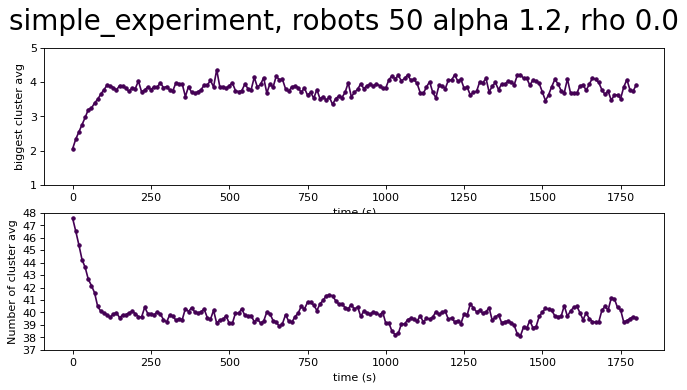

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.9_baseline_1800
Plotting


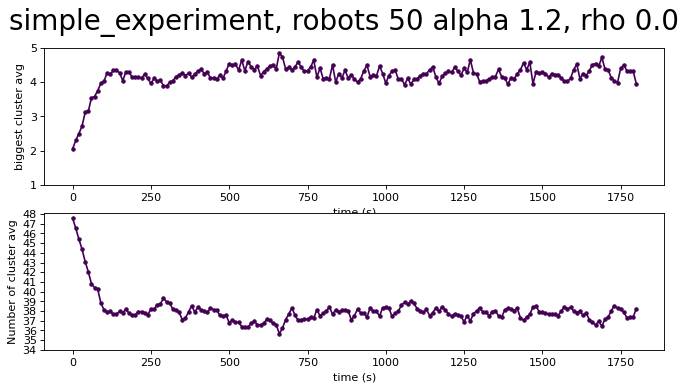

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.0_baseline_1800
Plotting


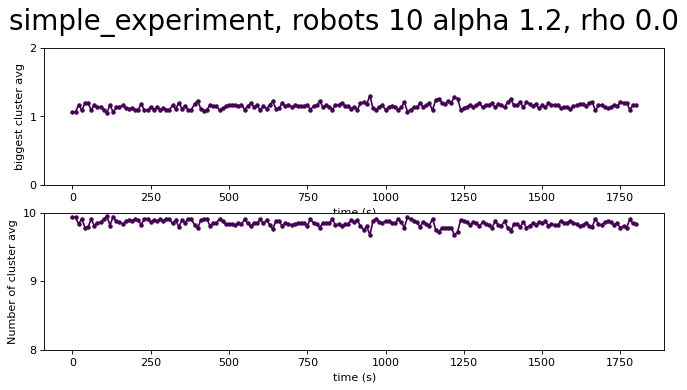

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.0_baseline_1800
Plotting


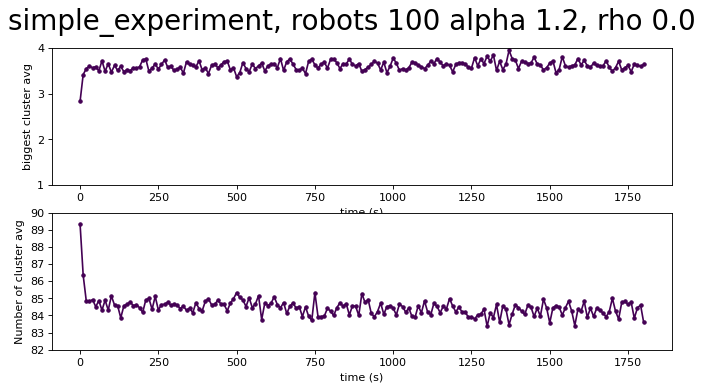

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.6_baseline_1800
Plotting


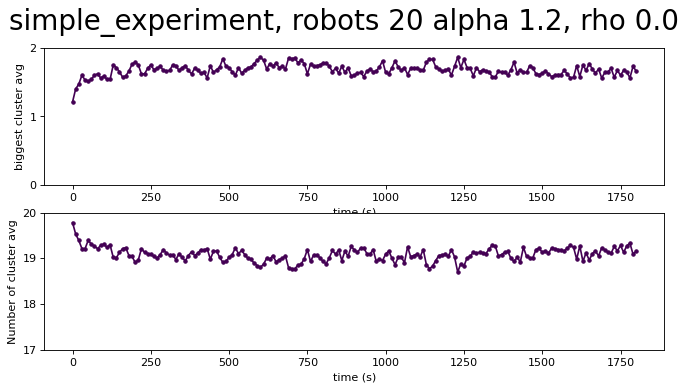

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.9_baseline_1800
Plotting


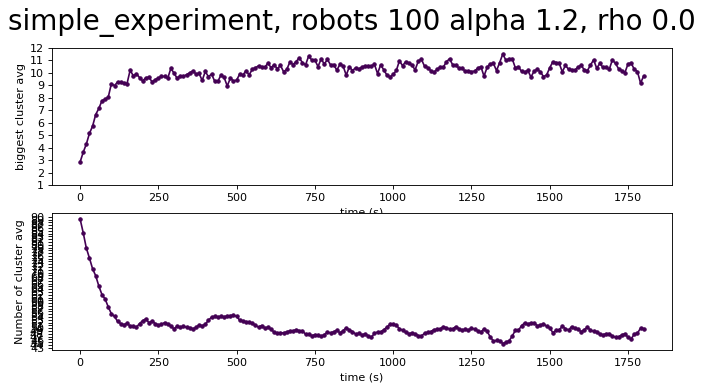

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.6_baseline_1800
Plotting


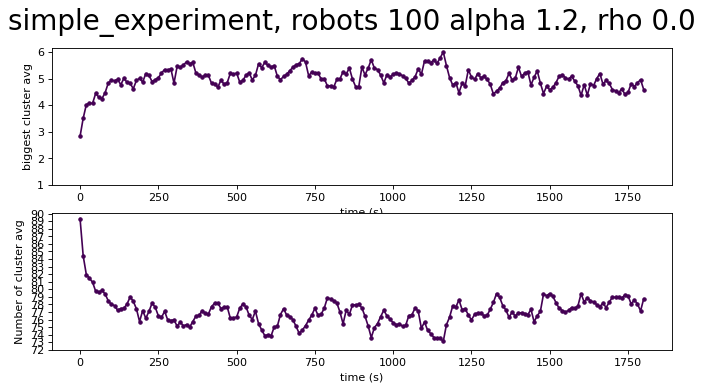

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.6_baseline_1800
Plotting


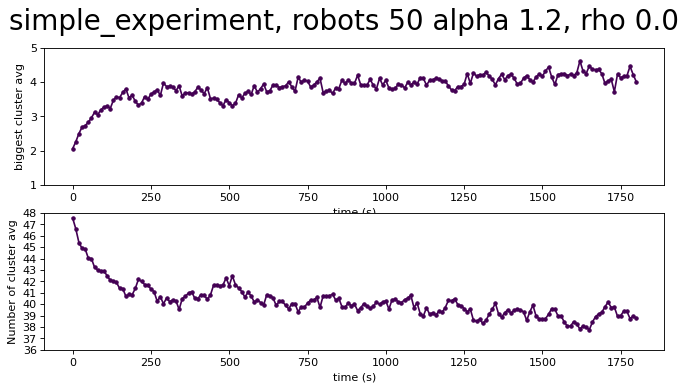

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.3_baseline_1800
Plotting


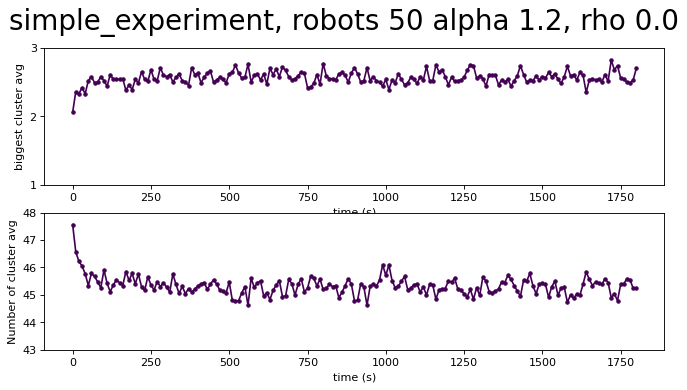

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.6_baseline_1800
Plotting


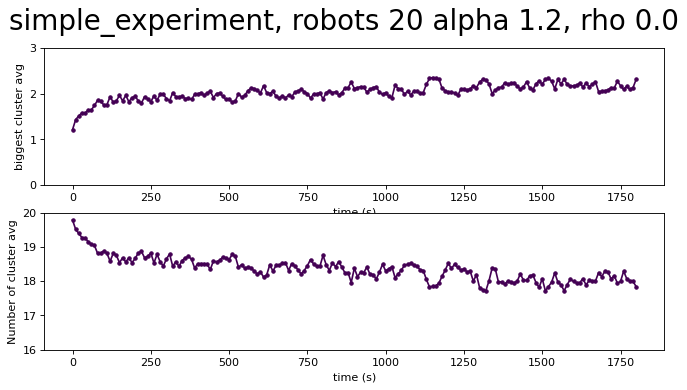

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.0_baseline_1800
Plotting


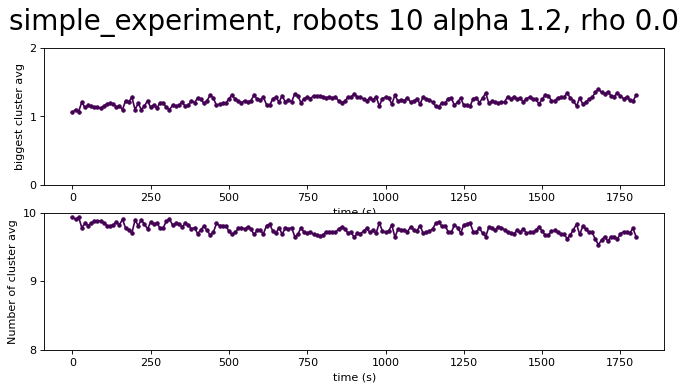

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.3_baseline_1800
Plotting


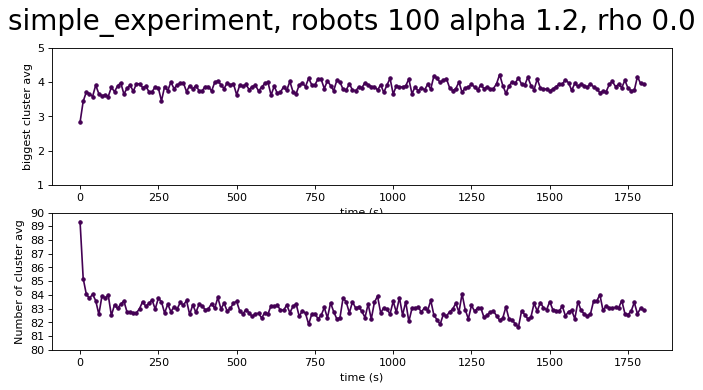

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.6_baseline_1800
Plotting


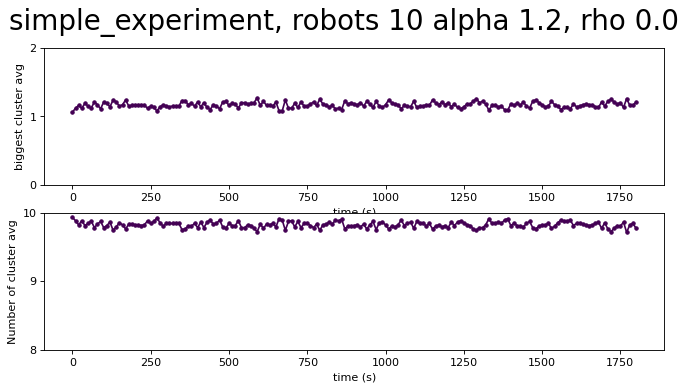

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.3_baseline_1800
Plotting


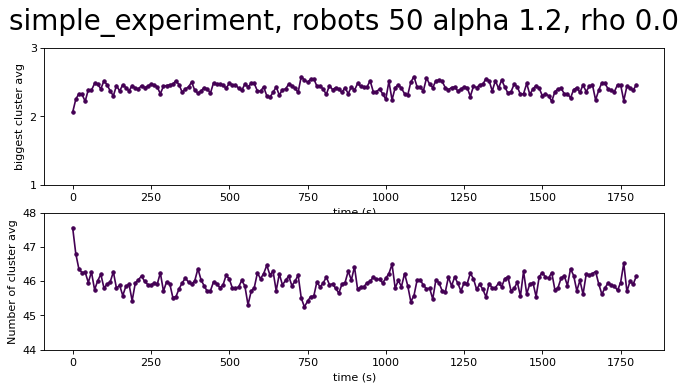

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.3_baseline_1800
Plotting


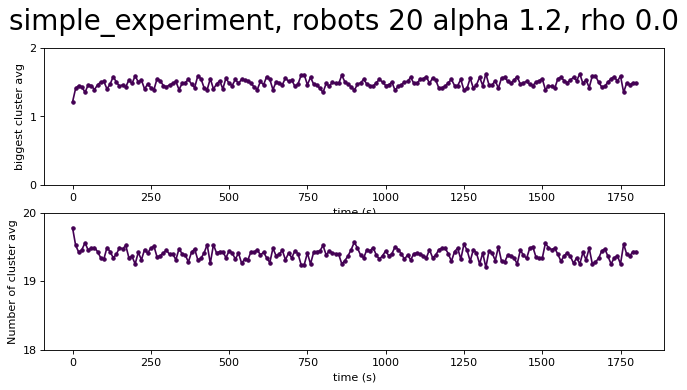

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.0_baseline_1800
Plotting


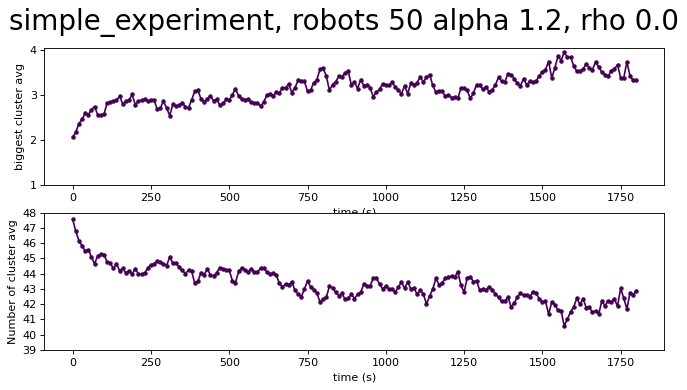

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.3_baseline_1800
Plotting


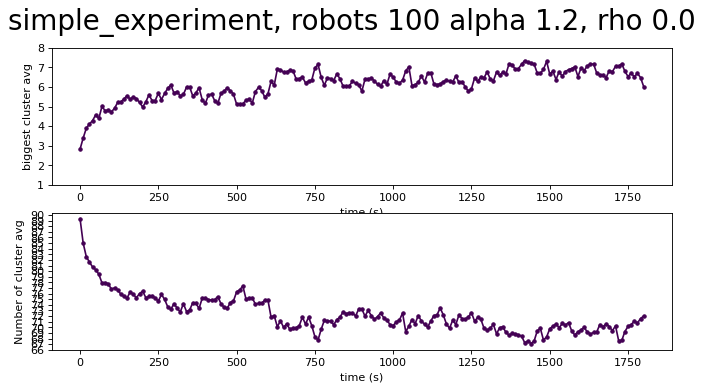

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.9_baseline_1800
Plotting


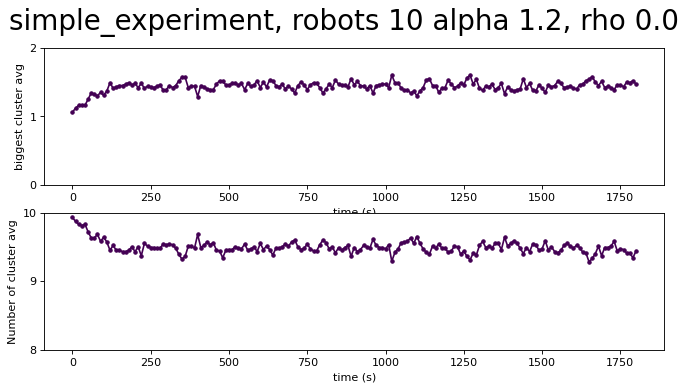

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.9_baseline_1800
Plotting


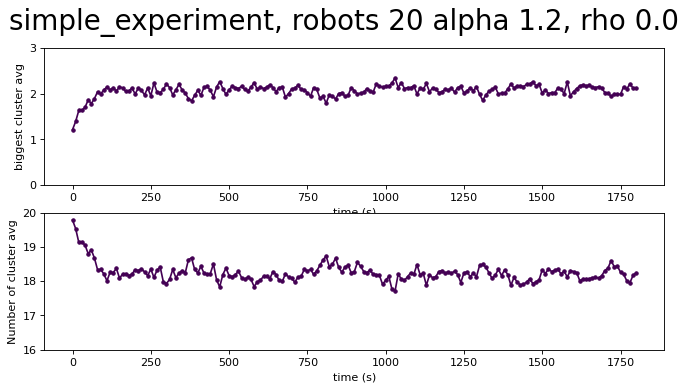

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.9_baseline_1800
Plotting


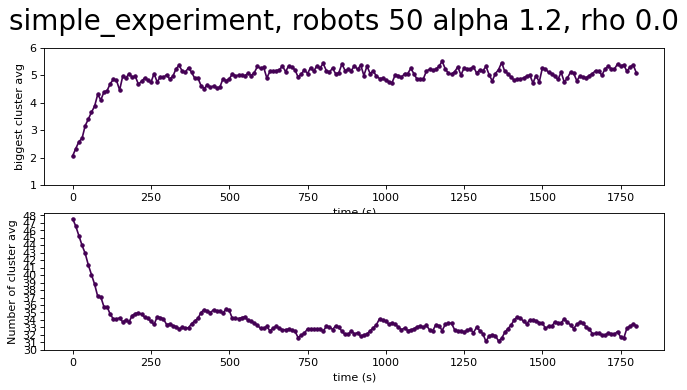

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.3_baseline_1800
Plotting


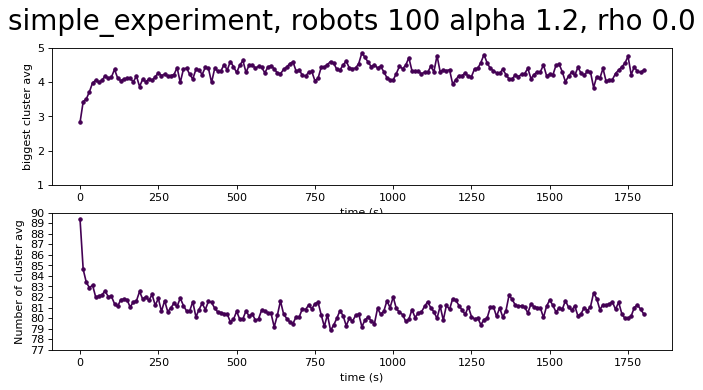

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.0_baseline_1800
Plotting


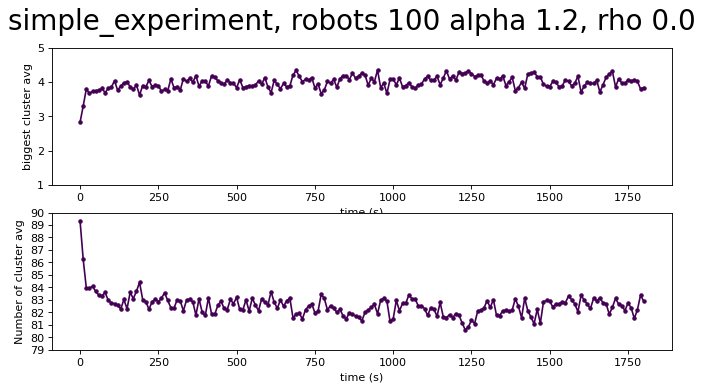

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.9_baseline_1800
Plotting


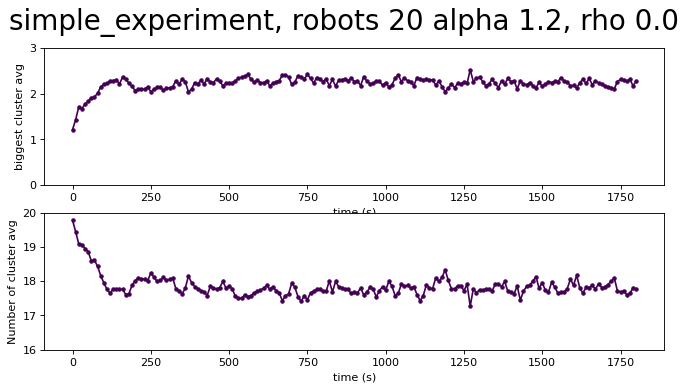

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.6_rho#0.9_baseline_1800
Plotting


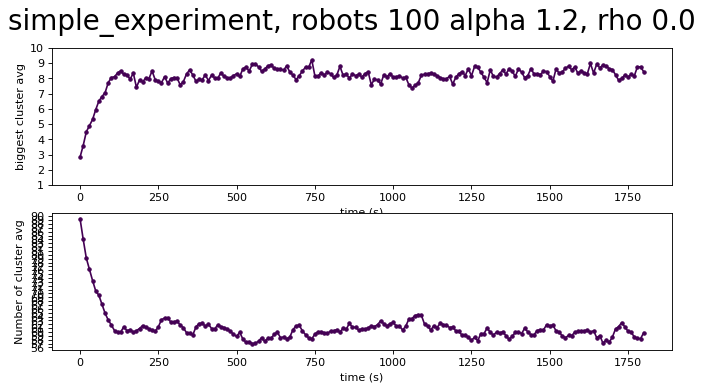

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.6_baseline_1800
Plotting


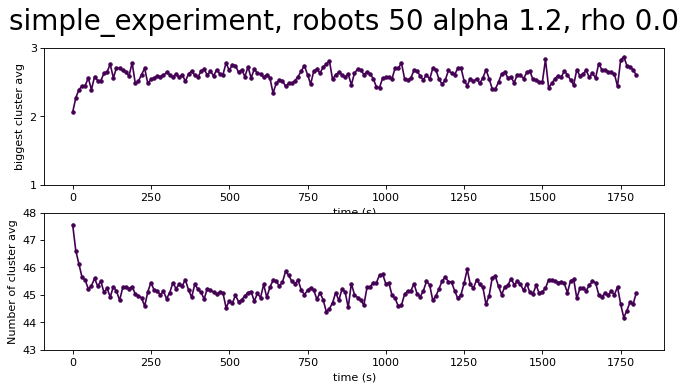

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.3_baseline_1800
Plotting


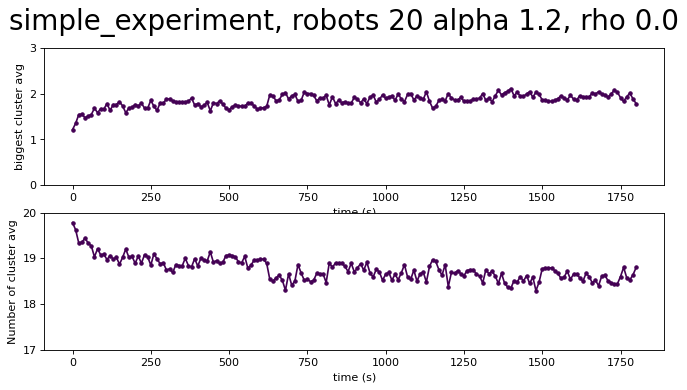

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.0_baseline_1800
Plotting


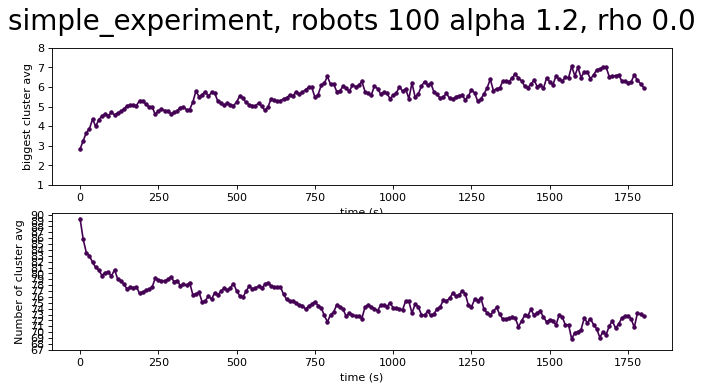

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.6_baseline_1800
Plotting


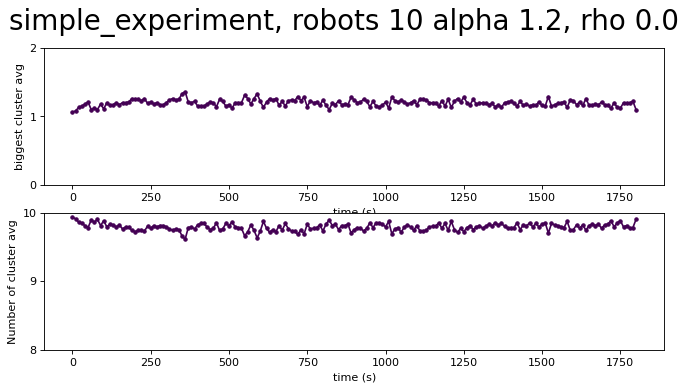

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.6_baseline_1800
Plotting


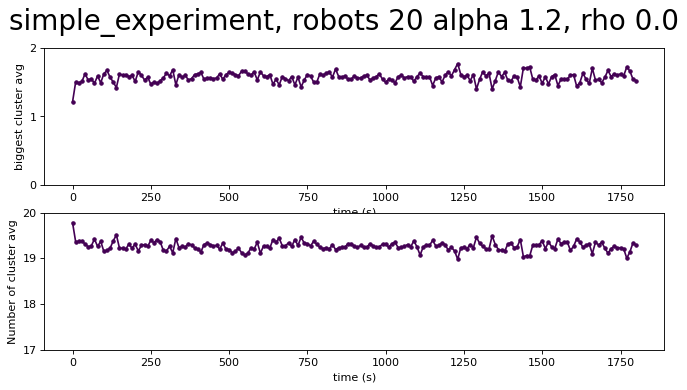

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.3_baseline_1800
Plotting


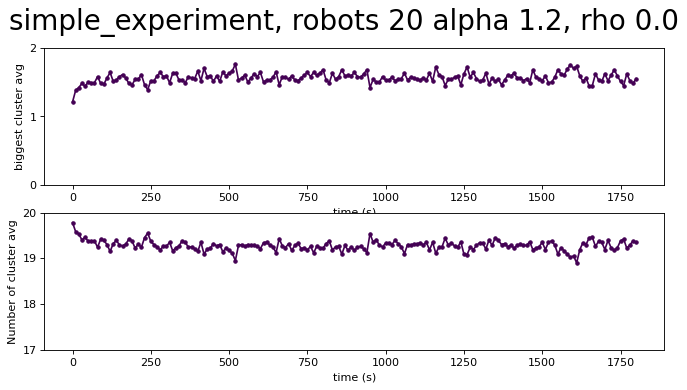

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#1.2_rho#0.6_baseline_1800
Plotting


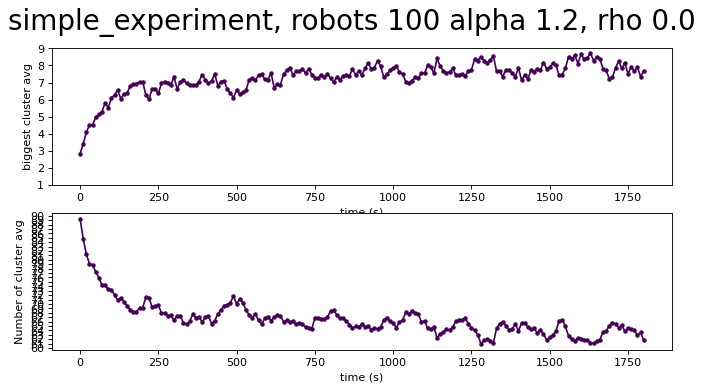

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.6_baseline_1800
Plotting


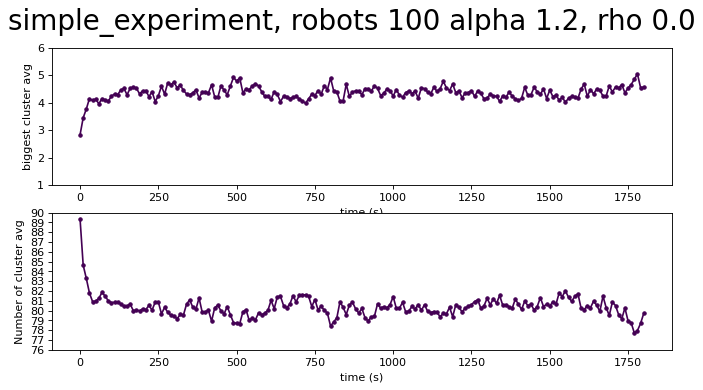

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.0_baseline_1800
Plotting


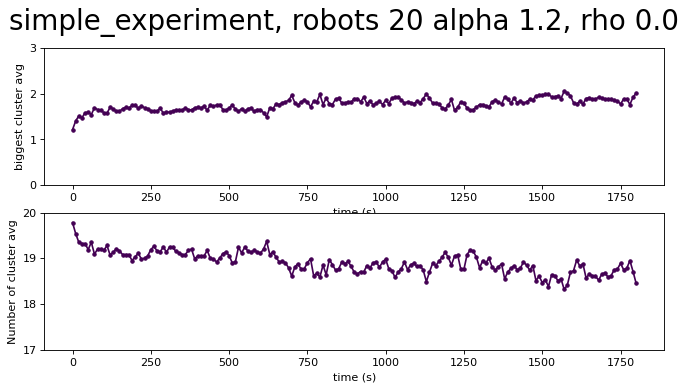

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.9_baseline_1800
Plotting


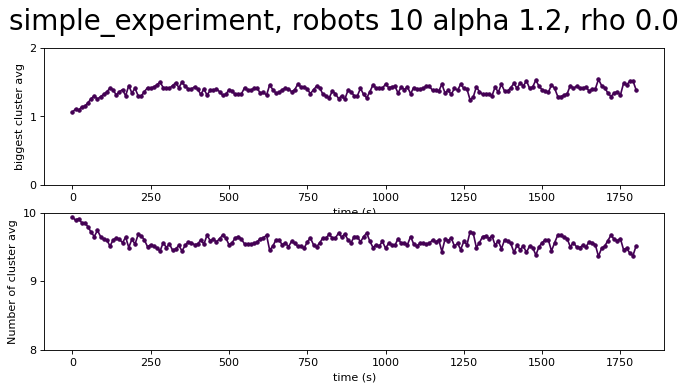

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.0_baseline_1800
Plotting


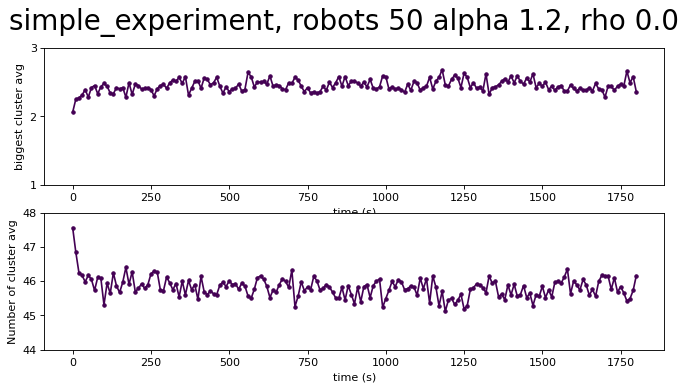

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#2.0_rho#0.0_baseline_1800
Plotting


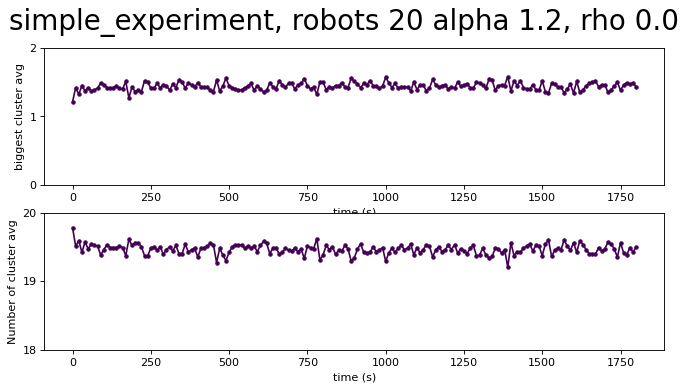

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.0_baseline_1800
Plotting


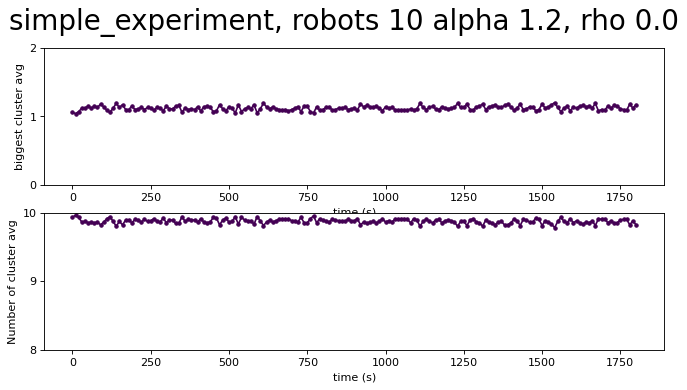

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#2.0_rho#0.3_baseline_1800
Plotting


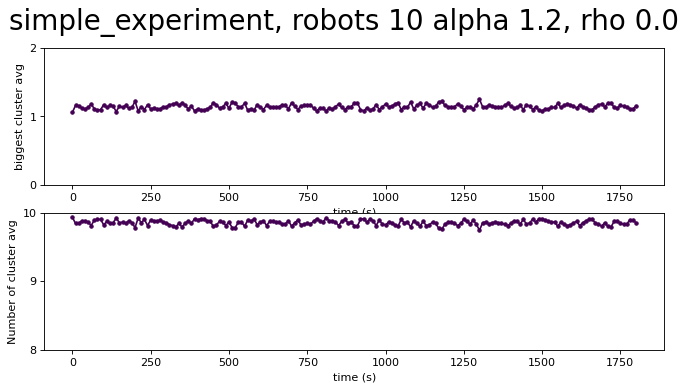

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.3_baseline_1800
Plotting


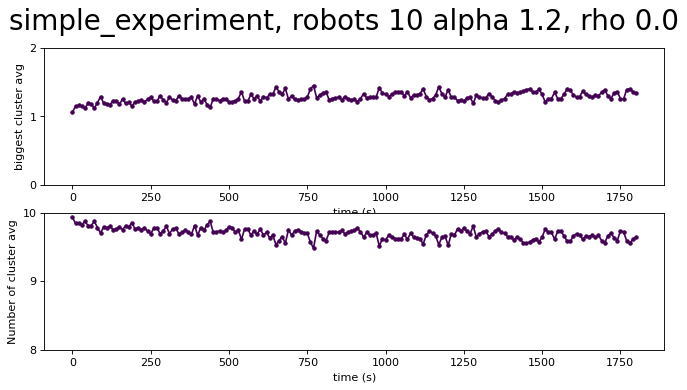

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.6_rho#0.6_baseline_1800
Plotting


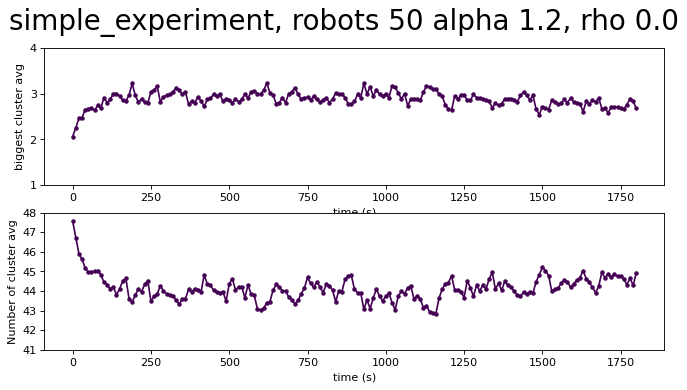

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.6_baseline_1800
Plotting


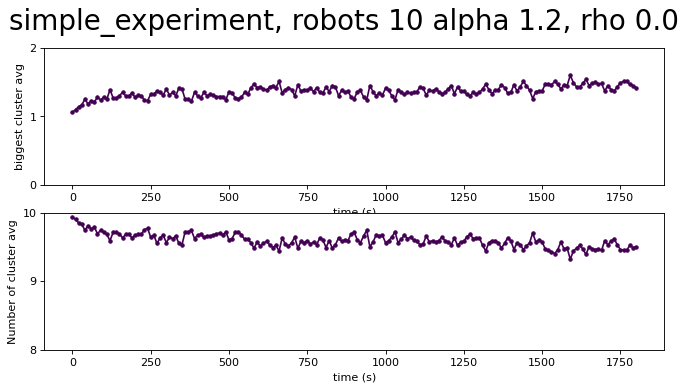

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.6_rho#0.0_baseline_1800
Plotting


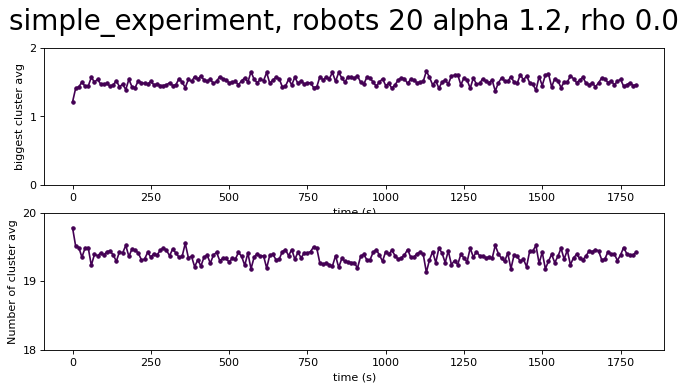

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.6_rho#0.3_baseline_1800
Plotting


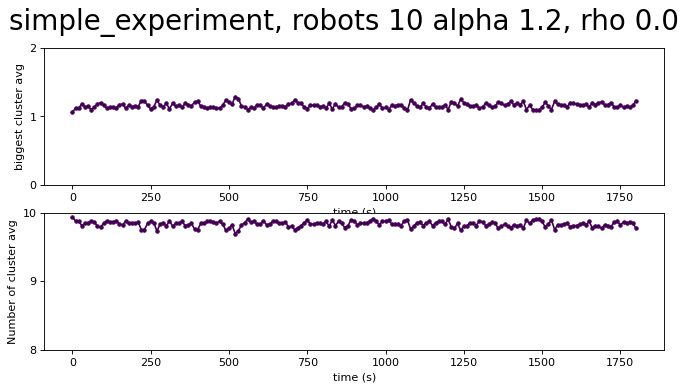

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#1.2_rho#0.3_baseline_1800
Plotting


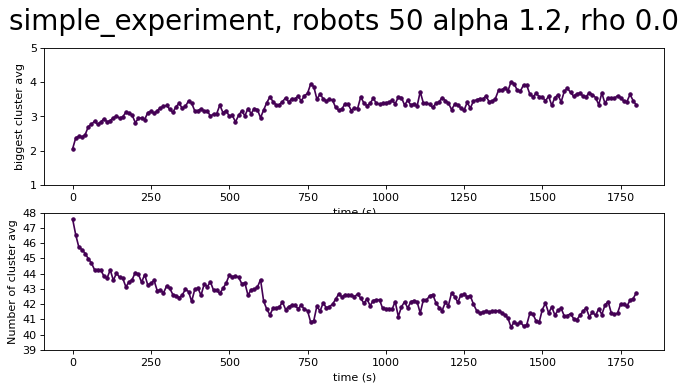

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#50_alpha#2.0_rho#0.0_baseline_1800
Plotting


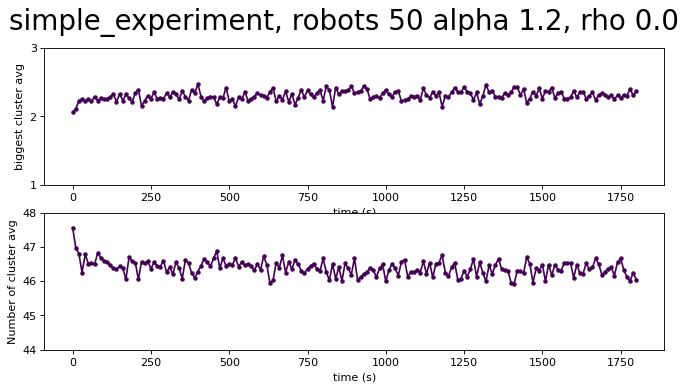

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#100_alpha#2.0_rho#0.9_baseline_1800
Plotting


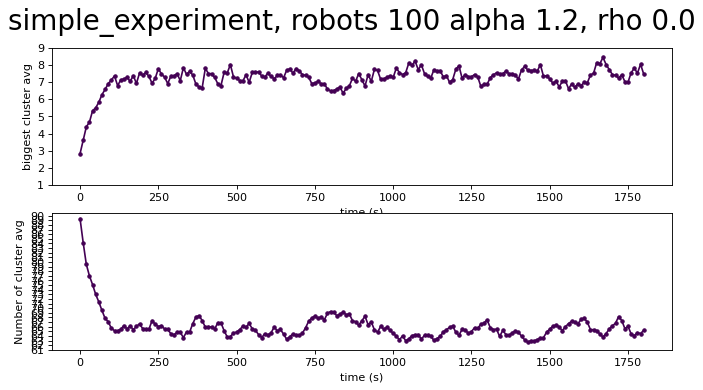

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#20_alpha#1.2_rho#0.9_baseline_1800
Plotting


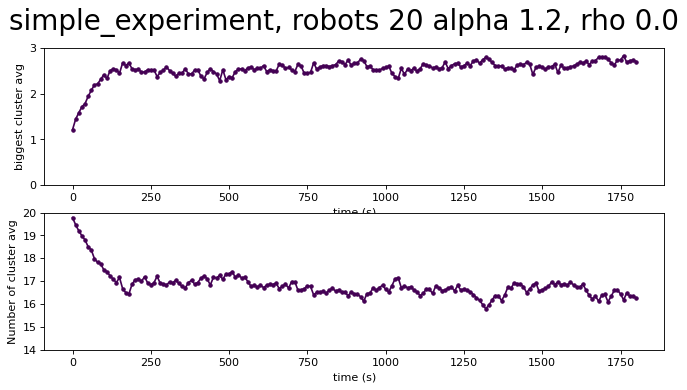

/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs/2020-06-03_robots#10_alpha#1.2_rho#0.9_baseline_1800
Plotting


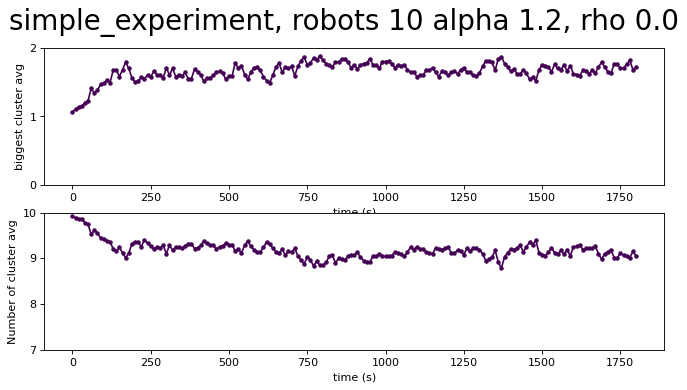

In [120]:
folder_experiment = '/home/luigi/Documents/ARGoS/argos_results_scripts/results/simple_experiment_100_runs'


for dirName, subdirList, fileList in os.walk(folder_experiment):
    biggest_clusters_avg = np.array([])
    n_clusters_avg = np.array([])
    
    num_robots = "-1"
    rho = -1.0
    alpha = -1.0
    elements = dirName.split("_")
    for e in elements:
        if e.startswith("robots"):
            num_robots = e.split("#")[-1]
        if (e.startswith("rho")):
            rho = float(e.split("#")[-1])
        if (e.startswith("alpha")):
            alpha = float(e.split("#")[-1])

    #         print(num_robots+' '+str(rho)+' '+str(alpha))
    if (num_robots == "-1" or rho == -1.0 or alpha == -1):
        continue
    else:
        print(dirName)
        runs = len([f for f in fileList if f.endswith('position.tsv')])
    #         print(runs)
        
    [_, df_experiment] = load_pd_positions(dirName, "experiment")
    positions_concatenated = df_experiment.values[:, 1:] #20 robots, 3 timesteps
    [num_robot, num_times] = positions_concatenated.shape
    positions_concatenated = np.array([x.split(',') for x in positions_concatenated.ravel()], dtype=float)
    positions_concatenated = positions_concatenated.reshape(num_robot, num_times, 2)
    position_concatenated_split = np.split(positions_concatenated, runs)
    
    
    for single_run in position_concatenated_split:
#         print('single run processing')
        biggest_clusters_per_time, n_clusters = get_connected_components(single_run)
        biggest_clusters_avg = np.vstack([biggest_clusters_avg, biggest_clusters_per_time]) if biggest_clusters_avg.size else biggest_clusters_per_time
        n_clusters_avg = np.vstack([n_clusters_avg, n_clusters]) if n_clusters_avg.size else n_clusters
    
    biggest_clusters_avg = np.mean(biggest_clusters_avg, axis=0)
    n_clusters_avg = np.mean(n_clusters_avg, axis=0)
    
    print('Plotting')
    plot_info_clusters(biggest_clusters_avg, n_clusters_avg)

In [75]:
n_clusters_avg.size

181

In [48]:
# labels_2d

In [43]:
positions_concatenated = df_experiment.values[:10, 1:] #20 robots, 3 timesteps
[num_robot, num_times] = positions_concatenated.shape
positions_concatenated = np.array([x.split(',') for x in positions_concatenated.ravel()], dtype=float)
positions_concatenated = positions_concatenated.reshape(num_robot, num_times, 2)

# questa può diventare una funzione che data la singola run ritorna 
# il vettore n_clusters e il vettore biggest_clusters_per_time
labels_2d = np.array([])
biggest_clusters_per_time = np.zeros(positions_concatenated.shape[1], dtype=int)
n_clusters = np.zeros(positions_concatenated.shape[1], dtype=int)
for c in range(positions_concatenated.shape[1]):
    xi = positions_concatenated[:,c,:]
    adjacency_matrix = np.zeros([xi.shape[0],xi.shape[0]], dtype=int)
    for i,ki in enumerate(xi):
        for j,kj in enumerate (xi[i+1:]):
    #         if(check_connection(ki,kj)):
    #             print(i,i+j+1,'\t',check_connection(ki,kj))
            adjacency_matrix[i,i+j+1] = check_connection(ki,kj)
            adjacency_matrix[i+j+1,i] = check_connection(ki,kj)
#     print(adjacency_matrix)
    adjacency_matrix = csr_matrix(adjacency_matrix) #cambiare nome
    n_cluster, labels = connected_components(csgraph=adjacency_matrix, directed=False, return_labels=True)
    biggest_clusters_per_time[c] = np.max(np.bincount(labels))
    n_clusters[c] = n_cluster
#     print("timestep %d : num_components %d" %(c, n_cluster))

In [45]:
print(prova_clusters)

[1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 2 2
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1]


In [46]:
np.array_equal(prova_clusters, biggest_clusters_per_time)

True

In [ ]:
# n_clusters

In [ ]:
# labels_2d

In [24]:
# biggest_clusters_per_time = np.max(np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=1, arr=labels_2d), axis=1)

In [47]:
# print(biggest_clusters_per_time)

In [81]:
min(n_clusters_avg)

9.53

In [82]:
math.floor(min(n_clusters_avg))

9

In [84]:
math.ceil(min(n_clusters_avg))

10

In [101]:
import colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

ModuleNotFoundError: No module named 'colormaps'

Text(0.5, 1.0, 'simple_experiment, robots 10 alpha 1.2, rho 0.0')

([<matplotlib.axis.YTick at 0x7f078a0d56a0>,
 <a list of 3 Text major ticklabel objects>)

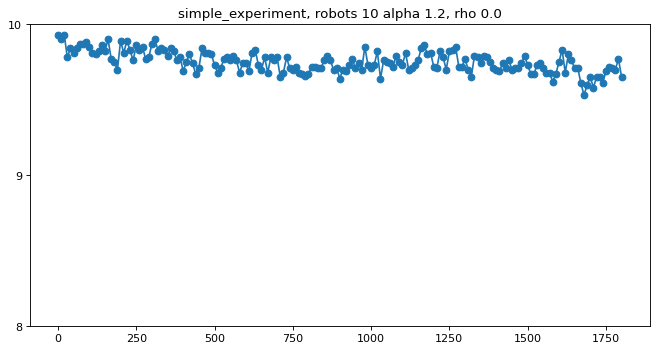

In [87]:
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(times, n_clusters_avg, label='cluster_0', marker='o')
plt.title('simple_experiment, robots '+str(num_robots)+' alpha 1.2, rho 0.0')

yint = range(math.floor(min(n_clusters_avg))-1, math.ceil(max(n_clusters_avg))+1)
plt.yticks(yint)

plt.show()

In [ ]:
biggest_clusters_avg

In [ ]:
x0 = positions_concatenated[:,6]

In [ ]:
x0.shape[0]

In [ ]:
adjacency_matrix = np.zeros([x0.shape[0],x0.shape[0]], dtype=int)
for i,ki in enumerate(x0):
    for j,kj in enumerate (x0[i+1:]):
#         if(check_connection(ki,kj)):
#             print(i,i+j+1,'\t',check_connection(ki,kj))
        adjacency_matrix[i,i+j+1] = check_connection(ki,kj)
        adjacency_matrix[i+j+1,i] = check_connection(ki,kj)

In [ ]:
# adjacency_matrix

In [ ]:
labels_2d = np.array([])
adjacency_matrix = csr_matrix(adjacency_matrix)

In [ ]:
# print(adjacency_matrix)

In [ ]:
n_components, labels = connected_components(csgraph=adjacency_matrix, directed=False, return_labels=True)

In [ ]:
n_components

In [30]:
labels = np.array([2,2,2,2,2,2,2,2,2,2])

In [34]:
labels_stack = np.array([])

In [39]:
labels_stack

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [38]:
labels_stack = np.vstack([labels_stack, labels]) if labels_stack.size else labels

In [ ]:
labels_2d

In [ ]:
np.max(np.bincount(np.array([2,2,2,2,2,2,2,2,2,2])))